In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import convolve


def canny_edge_detection(image_path, low_threshold=20, high_threshold=60, sigma=1.0):
    """
    实现Canny边缘检测算法
    
    参数:
        image_path: 输入图像路径或图像数组
        low_threshold: 低阈值
        high_threshold: 高阈值
        sigma: 高斯滤波器的标准差
    
    返回:
        edge_map: 边缘检测结果，二值图像
        gradient_magnitude: 梯度幅值图像
    """
    # 1. 读取图像
    if isinstance(image_path, str):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    else:
        img = image_path
        # 如果是彩色图，转换为灰度图
        if len(img.shape) > 2:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 确保图像是无符号8位整数类型
    if img.dtype != np.uint8: 
        img = img.astype(np.uint8)
    
    # 转换为float类型，方便计算
    img = img.astype(np.float64)
    
    # 2. 高斯平滑
    # 生成高斯滤波器
    filter_size = 2 * int(np.ceil(3 * sigma)) + 1  # 滤波器大小，保证覆盖3个标准差
    gauss_filter = gaussian_kernel(filter_size, sigma)
    
    # 应用高斯滤波
    smoothed_img = convolve(img, gauss_filter)
    
    # 3. 计算梯度幅值和方向
    # 定义Sobel算子
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    # 计算x和y方向的梯度
    gradient_x = convolve(smoothed_img, sobel_x)
    gradient_y = convolve(smoothed_img, sobel_y)
    
    # 计算梯度幅值和方向
    gradient_magnitude = np.sqrt(gradient_x**2 + gradient_y**2)
    gradient_direction = np.arctan2(gradient_y, gradient_x) * 180 / np.pi
    # 将角度转换为0-180度范围
    gradient_direction = np.mod(gradient_direction, 180)
    
    # 4. 非极大值抑制
    rows, cols = gradient_magnitude.shape
    suppressed = np.zeros_like(gradient_magnitude)
    
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            # 获取当前像素的梯度方向
            direction = gradient_direction[i, j]
            
            # 将方向量化为0，45，90，135度
            if (direction >= 0 and direction < 22.5) or (direction >= 157.5 and direction < 180):
                neighbors = [gradient_magnitude[i, j+1], gradient_magnitude[i, j-1]]
            elif direction >= 22.5 and direction < 67.5:
                neighbors = [gradient_magnitude[i-1, j+1], gradient_magnitude[i+1, j-1]]
            elif direction >= 67.5 and direction < 112.5:
                neighbors = [gradient_magnitude[i-1, j], gradient_magnitude[i+1, j]]
            else:
                neighbors = [gradient_magnitude[i-1, j-1], gradient_magnitude[i+1, j+1]]
            
            # 如果当前像素的梯度幅值大于其梯度方向上的邻居，则保留
            if gradient_magnitude[i, j] >= max(neighbors):
                suppressed[i, j] = gradient_magnitude[i, j]
    
    # 5. 双阈值处理和滞后阈值处理
    edge_map = np.zeros_like(suppressed)
    strong_edges = suppressed >= high_threshold
    weak_edges = (suppressed >= low_threshold) & (suppressed < high_threshold)
    
    # 标记强边缘
    edge_map[strong_edges] = 1
    
    # 连接弱边缘
    for i in range(1, rows-1):
        for j in range(1, cols-1):
            if weak_edges[i, j]:
                # 检查8邻域内是否有强边缘
                if np.any(edge_map[i-1:i+2, j-1:j+2]):
                    edge_map[i, j] = 1
    
    return edge_map, gradient_magnitude


def gaussian_kernel(size, sigma):
    """
    创建高斯滤波器
    
    参数:
        size: 滤波器大小
        sigma: 高斯函数的标准差
    
    返回：
        kernel: 高斯滤波器
    """
    # 确保size是奇数
    if size % 2 == 0:
        size = size + 1
    
    # 计算滤波器的中心
    center = (size - 1) // 2
    
    # 创建网格
    x, y = np.meshgrid(np.arange(-center, center+1), np.arange(-center, center+1))
    
    # 计算高斯函数
    kernel = np.exp(-(x**2 + y**2) / (2 * sigma**2))
    
    # 归一化滤波器，使得权重和为1
    kernel = kernel / np.sum(kernel)
    
    return kernel



def display_results(image_path, low_threshold=20, high_threshold=60, sigma=1.0):
    """
    显示原始图像、梯度幅值图像和边缘检测结果
    
    参数:
        image_path: 输入图像路径或图像数组
        low_threshold: 低阈值
        high_threshold: 高阈值
        sigma: 高斯滤波器的标准差
    """
    # 读取原始图像
    if isinstance(image_path, str):
        original_img = cv2.imread(image_path)
        original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)  # 转换为RGB
    else:
        original_img = image_path
        if len(original_img.shape) == 2:  # 如果是灰度图，转换为RGB
            original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
        elif original_img.shape[2] == 3 and original_img.dtype == np.uint8:
            original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    # 执行Canny边缘检测，获取边缘图和梯度幅值图
    edge_map, gradient_magnitude = canny_edge_detection(image_path, low_threshold, high_threshold, sigma)
    
    # 归一化梯度幅值图像，使其值范围在[0, 255]
    gradient_magnitude_normalized = (gradient_magnitude / np.max(gradient_magnitude) * 255).astype(np.uint8)
    
    # 创建图像显示
    plt.figure(figsize=(15, 5))
    
    # 显示原始图像
    plt.subplot(1, 3, 1)
    plt.imshow(original_img)
    plt.title('Original Image')
    plt.axis('off')
    
    # 显示梯度幅值图像
    plt.subplot(1, 3, 2)
    plt.imshow(gradient_magnitude_normalized, cmap='gray')
    plt.title('Gradient Magnitude')
    plt.axis('off')
    
    # 显示边缘检测结果
    plt.subplot(1, 3, 3)
    plt.imshow(edge_map, cmap='gray')
    plt.title('Edge Detection Result')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()





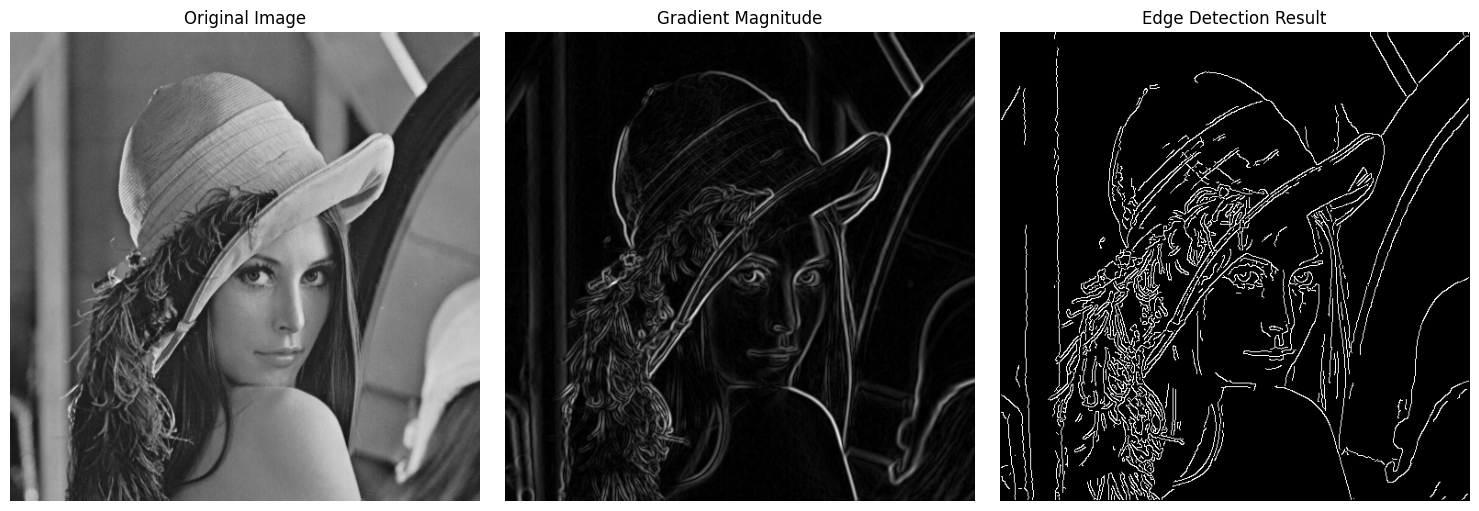

In [24]:
# 读取图像
image_path = 'images/Q1.tif'

# 设置参数
low_threshold = 20   # 低阈值
high_threshold = 60  # 高阈值
sigma = 1.0          # 高斯滤波器的标准差

# # 运行Canny边缘检测
# edge_map = canny_edge_detection(image_path, low_threshold, high_threshold, sigma)

# # 显示结果
# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
# plt.imshow(img, cmap='gray')
# plt.title('Original Image')

# plt.subplot(1, 2, 2)
# plt.imshow(edge_map, cmap='gray')
# plt.title('Canny Edge Detection Result')

# # 保存结果
# plt.tight_layout()
# cv2.imwrite('canny_result.png', edge_map * 255)
# print('边缘检测完成，结果已保存为canny_result.png')

# plt.show()

display_results( image_path , low_threshold=20, high_threshold=60, sigma=1.0)


In [36]:
def calculate_iou(predicted_edges, ground_truth_edges):
    """
    计算交并比（IoU）
    
    参数:
        predicted_edges: 预测的边缘图，二值图像
        ground_truth_edges: 真实的边缘图，二值图像
    
    返回:
        iou: 交并比
    """
    # 确保输入是二值图像
    if predicted_edges.dtype != bool:
        predicted_edges = predicted_edges.astype(bool)
    if ground_truth_edges.dtype != bool:
        ground_truth_edges = ground_truth_edges.astype(bool)
    
    # 计算交集和并集
    intersection = np.logical_and(predicted_edges, ground_truth_edges)
    union = np.logical_or(predicted_edges, ground_truth_edges)
    
    # 计算IoU
    iou = np.sum(intersection) / np.sum(union) if np.sum(union) > 0 else 0
    
    return iou



In [20]:
import scipy.io

# 读取MAT文件
mat_file_path = "GT/Q1_segmentation.mat"  # 替换为你的MAT文件路径
data = scipy.io.loadmat(mat_file_path)

# 查看读取的数据
print(data)

GT=data["final_edges"]


iou=calculate_iou(edge_map, GT)

print("IoU:",iou)

IoU: 0.5431780846246059


## Q2

Image shape: (195, 346, 3)


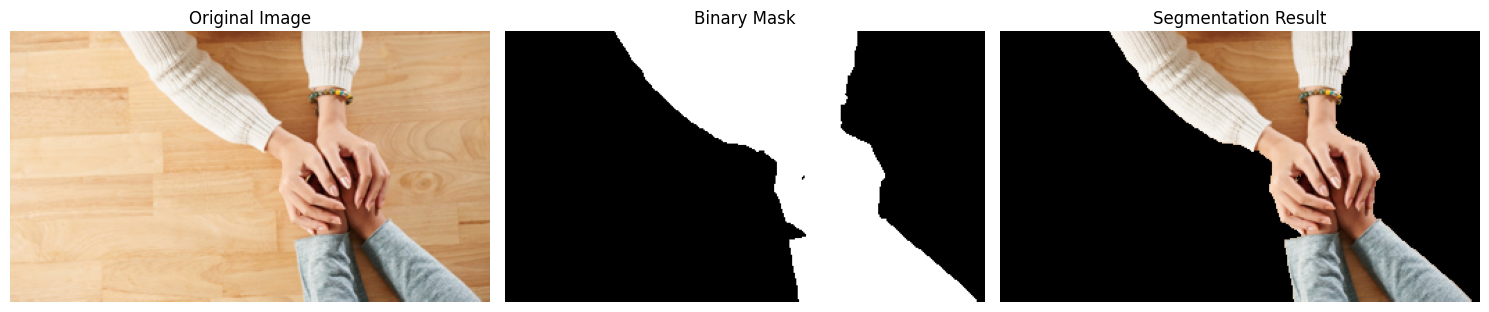

True

In [47]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# 读取图像
img = cv.imread("images/Q2_1.png")
print(f"Image shape: {img.shape}")

# 创建一个图像副本用于显示原始图像
original_img = img.copy()

# 初始化掩码和模型
mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# 定义前景矩形区域
rect = (50, 0, 340-50, 195)

# 执行GrabCut算法
cv.grabCut(img, mask, rect, bgdModel, fgdModel, 20, cv.GC_INIT_WITH_RECT)

# 创建二值掩码
# 0和2表示背景，1和3表示前景
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# 应用掩码到原始图像以获取分割结果
segmented_img = img * mask2[:, :, np.newaxis]

# 将BGR转换为RGB用于matplotlib显示
original_img_rgb = cv.cvtColor(original_img, cv.COLOR_BGR2RGB)
segmented_img_rgb = cv.cvtColor(segmented_img, cv.COLOR_BGR2RGB)

# 创建一个包含三个子图的图形
plt.figure(figsize=(15, 5))

# 显示原始图像
plt.subplot(131)
plt.imshow(original_img_rgb)
plt.title('Original Image')
plt.axis('off')

# 显示二值掩码
plt.subplot(132)
plt.imshow(mask2, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

# 显示分割结果
plt.subplot(133)
plt.imshow(segmented_img_rgb)
plt.title('Segmentation Result')
plt.axis('off')

plt.tight_layout()
plt.show()

# 可选：保存结果
cv.imwrite('images/Q2_1/original.png', original_img)
cv.imwrite('images/Q2_1/binary_mask.png', mask2 * 255)
cv.imwrite('images/Q2_1/segmentation_result.png', segmented_img)


In [37]:
import scipy.io

mat_file_path = "GT/Q2_1_segmentation.mat" 
data = scipy.io.loadmat(mat_file_path)

# 查看读取的数据
print(data)

GT=data["segmentation_mask"]


iou=calculate_iou(mask, GT)

print("IoU:",iou)

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Tue Mar 18 01:00:22 2025', '__version__': '1.0', '__globals__': [], 'segmentation_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(195, 346), dtype=uint8)}
IoU: 0.2870026525198939


Image shape: (384, 512, 3)


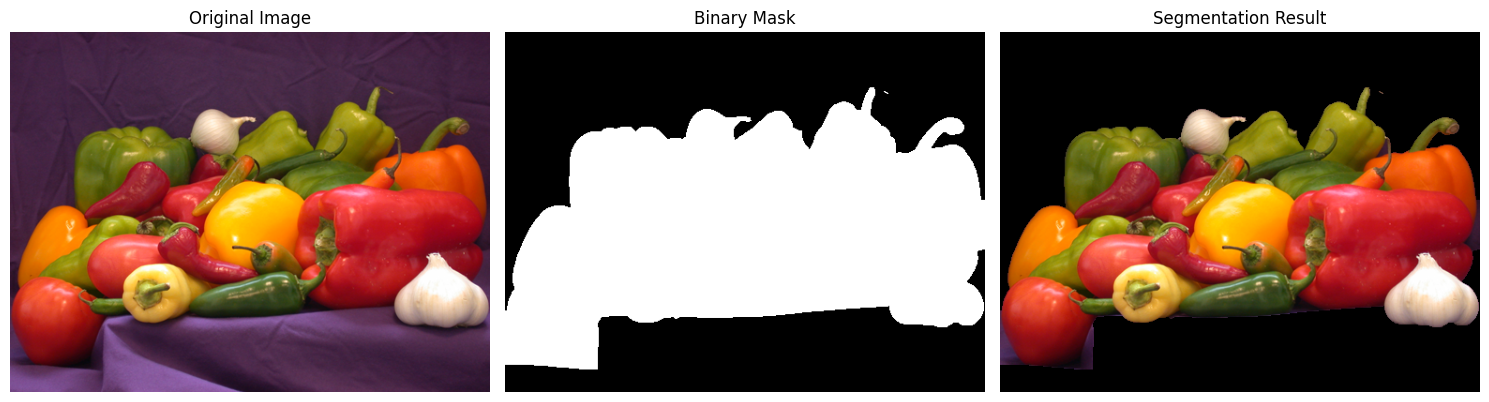

True

In [48]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

# 读取图像
img = cv.imread("images/Q2_2.png")
print(f"Image shape: {img.shape}")

# 创建一个图像副本用于显示原始图像
original_img = img.copy()

# 初始化掩码和模型
mask = np.zeros(img.shape[:2], np.uint8)
bgdModel = np.zeros((1, 65), np.float64)
fgdModel = np.zeros((1, 65), np.float64)

# 定义前景矩形区域
rect = (0, 50, 512, 310)

# 执行GrabCut算法
cv.grabCut(img, mask, rect, bgdModel, fgdModel, 10, cv.GC_INIT_WITH_RECT)

# 创建二值掩码
# 0和2表示背景，1和3表示前景
mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

# 应用掩码到原始图像以获取分割结果
segmented_img = img * mask2[:, :, np.newaxis]

# 将BGR转换为RGB用于matplotlib显示
original_img_rgb = cv.cvtColor(original_img, cv.COLOR_BGR2RGB)
segmented_img_rgb = cv.cvtColor(segmented_img, cv.COLOR_BGR2RGB)

# 创建一个包含三个子图的图形
plt.figure(figsize=(15, 5))

# 显示原始图像
plt.subplot(131)
plt.imshow(original_img_rgb)
plt.title('Original Image')
plt.axis('off')

# 显示二值掩码
plt.subplot(132)
plt.imshow(mask2, cmap='gray')
plt.title('Binary Mask')
plt.axis('off')

# 显示分割结果
plt.subplot(133)
plt.imshow(segmented_img_rgb)
plt.title('Segmentation Result')
plt.axis('off')

plt.tight_layout()
plt.show()

cv.imwrite('images/Q2_2/original.png', original_img)
cv.imwrite('images/Q2_2/binary_mask.png', mask2 * 255)
cv.imwrite('images/Q2_2/segmentation_result.png', segmented_img)

In [44]:
import scipy.io

mat_file_path = "GT/Q2_2_segmentation.mat" 
data = scipy.io.loadmat(mat_file_path)

# 查看读取的数据
print(data)

GT=data["segmentation_mask"]


iou=calculate_iou(mask, GT)

print("IoU:",iou)

{'__header__': b'MATLAB 5.0 MAT-file Platform: nt, Created on: Tue Mar 18 00:02:53 2025', '__version__': '1.0', '__globals__': [], 'segmentation_mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(384, 512), dtype=uint8)}
IoU: 0.6215347782258065
